# Final AI/ML Project Model Exploration

This script utilizes Masshchusetts school-level data to investigate if education policy and school-level characteristics in Massachusetts can predict student outcomes, which can inform discussions on policy and funding. 

## Data Cleaning

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import warnings
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, roc_auc_score,
    recall_score, precision_score, precision_recall_curve,
    auc, f1_score, make_scorer
)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TunedThresholdClassifierCV
import statsmodels.api as sm

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, classification_report
import seaborn as sns

In [2]:
# Importing data and cleaning categorical predictors

all_results = []

data = pd.read_csv("/Users/kaylenamann/Downloads/BC Grad/2025Fall_ADAN7430/assignments/Final_Project/Raw Data/EducationData.csv")
years = sorted(data["year"].unique())

train_years = years[:-1]
test_year   = years[-1]

train_data = data[data["year"].isin(train_years)].copy()
test_data  = data[data["year"] == test_year].copy()

for df in [train_data, test_data]:

    df["title_i_binary"] = df["title_i_status"].apply(
        lambda x: 1 if "eligible" in str(x).lower() else 0
    )

    df["school_level_clean"] = df["school_level"].replace({
        "Prekindergarten": "Elementary",
        "Elementary": "Elementary",
        "Primary": "Elementary",
        "Middle": "Middle",
        "Secondary": "High",
        "High": "High"
    }).fillna("Other")

    df["school_type_clean"] = df["school_type"].replace({
        "Special education school": "Specialized",
        "Vocational school": "Specialized"
    })

    df["math_test_pct_prof_midpt"] = pd.to_numeric(
        df["math_test_pct_prof_midpt"], errors="coerce"
    )

## Defining Outcome
To classify schools as low-proficiency, we are computing below 25% (1) versus above 25% (0) 

In [3]:
cutoff = train_data["math_test_pct_prof_midpt"].dropna().quantile(0.25)

train_data["y"] = (train_data["math_test_pct_prof_midpt"] <= cutoff).astype(int)
test_data["y"]  = (test_data["math_test_pct_prof_midpt"] <= cutoff).astype(int)

train_data = train_data.dropna(subset=["y"])
test_data  = test_data.dropna(subset=["y"])

y_train = train_data["y"]
y_test  = test_data["y"]

print("Class balance (train):", y_train.value_counts(normalize=True).round(3))
print(f"Training samples: {len(y_train)}, Test samples: {len(y_test)}")

Class balance (train): y
0    0.758
1    0.242
Name: proportion, dtype: float64
Training samples: 3742, Test samples: 1872


## Building Train/Test Split

In [5]:
predictors = [
    "enrollment", "direct_certification",
    "meps_poverty_pct", "meps_mod_poverty_pct",
    "school_level_clean", "school_type_clean",
    "charter", "title_i_binary", "state_location"
]

#Creating dummies from categories
X_train = pd.get_dummies(train_data[predictors], drop_first=True)
X_test  = pd.get_dummies(test_data[predictors], drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Impute missing and Scale
imputer = SimpleImputer(strategy="mean")
scaler  = StandardScaler()

#Creating train/test for different models
X_train_imp = imputer.fit_transform(X_train) #imputed
X_test_imp  = imputer.transform(X_test)
X_train_scaled = scaler.fit_transform(X_train_imp) #scaled
X_test_scaled  = scaler.transform(X_test_imp)
X_train_tree = imputer.fit_transform(X_train)  #For decision tree
X_test_tree  = imputer.transform(X_test)

## Box-tidwell Test for non-linearity

In [6]:
continuous_vars = [
    "enrollment",
    "direct_certification",
    "meps_poverty_pct",
    "meps_mod_poverty_pct"
]

X_bt = train_data[continuous_vars].copy()

eps = 1e-6 #adding in small value to avoid infinity issues (score of 0)

#Creating log term
for var in continuous_vars:
    X_bt[f"{var}_logint"] = X_bt[var] * np.log(X_bt[var] + eps)
X_bt = X_bt.replace([np.inf, -np.inf], np.nan).dropna()
y_bt = y_train.loc[X_bt.index]

X_bt_sm = sm.add_constant(X_bt)

bt_model = sm.GLM(
    y_bt,
    X_bt_sm,
    family=sm.families.Binomial()
)

bt_results = bt_model.fit()

print("="*80)
print("BOX–TIDWELL RESULTS")
print("="*80)
print(bt_results.summary())

print("\nLog-interaction term significance:")
for var in continuous_vars:
    term = f"{var}_logint"
    pval = bt_results.pvalues.get(term, np.nan)
    sig = "***" if pval < 0.001 else "**" if pval < 0.01 else "*" if pval < 0.05 else ""
    print(f"{term:30s} p = {pval:.4f} {sig}")

BOX–TIDWELL RESULTS
                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 3629
Model:                            GLM   Df Residuals:                     3620
Model Family:                Binomial   Df Model:                            8
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1184.7
Date:                Thu, 18 Dec 2025   Deviance:                       2369.4
Time:                        18:52:16   Pearson chi2:                 2.94e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3733
Covariance Type:            nonrobust                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

Poverty is borderline non-linear and has historical non-linear relationship with academic scores, so we will test if a squared term improves accuracy.

In [7]:
#Creating a function to evaluate models 
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    pr_auc = auc(recall, precision)

    print("\n" + "="*80)
    print(f"{name}")
    print("="*80)
    print(f"Accuracy:  {accuracy_score(y_test, y_pred):.3f}")
    print(f"Recall:    {recall_score(y_test, y_pred):.3f}")
    print(f"Precision: {precision_score(y_test, y_pred):.3f}")
    print(f"F1 Score:  {f1_score(y_test, y_pred):.3f}")
    print(f"ROC AUC:   {roc_auc_score(y_test, y_prob):.3f}")
    print(f"PR AUC:    {pr_auc:.3f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

## Base Logistic Model

In [8]:
base_logit = LogisticRegression(
    max_iter=5000,
    class_weight="balanced",
    random_state=42
)
base_logit.fit(X_train_scaled, y_train)
evaluate_model("Baseline Logistic Regression", base_logit, X_test_scaled, y_test)


Baseline Logistic Regression
Accuracy:  0.838
Recall:    0.770
Precision: 0.652
F1 Score:  0.706
ROC AUC:   0.892
PR AUC:    0.748

Confusion Matrix:
[[1203  195]
 [ 109  365]]


## Ridge logistic

In [9]:
ridge_logit = LogisticRegressionCV(
    Cs=10,
    cv=5,
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced",
    scoring="roc_auc",
    max_iter=5000,
    random_state=33
)
ridge_logit.fit(X_train_scaled, y_train)
evaluate_model("Ridge Logistic Regression", ridge_logit, X_test_scaled, y_test)


Ridge Logistic Regression
Accuracy:  0.839
Recall:    0.772
Precision: 0.655
F1 Score:  0.709
ROC AUC:   0.892
PR AUC:    0.748

Confusion Matrix:
[[1205  193]
 [ 108  366]]


## Decision Tree

In [10]:
dtree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=100,
    min_samples_leaf=50,
    class_weight="balanced",
    random_state=42
)
dtree.fit(X_train_tree, y_train)
evaluate_model("Decision Tree", dtree, X_test_tree, y_test)


Decision Tree
Accuracy:  0.821
Recall:    0.846
Precision: 0.605
F1 Score:  0.705
ROC AUC:   0.897
PR AUC:    0.724

Confusion Matrix:
[[1136  262]
 [  73  401]]


## Clustering

In [11]:
knn_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(n_neighbors=11))
])

best_knn_model = TunedThresholdClassifierCV(
    knn_pipe,
    scoring=make_scorer(f1_score),
    cv=5,
    random_state=42
)

best_knn_model.fit(X_train, y_train)
evaluate_model("KNN (Threshold Tuned)", best_knn_model, X_test, y_test)


KNN (Threshold Tuned)
Accuracy:  0.819
Recall:    0.709
Precision: 0.627
F1 Score:  0.665
ROC AUC:   0.872
PR AUC:    0.726

Confusion Matrix:
[[1198  200]
 [ 138  336]]


In [12]:
# Compiled results
def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    return {
        "auc": roc_auc_score(y_test, y_prob),
        "f1": f1_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred)
    }

baseline_metrics = get_metrics(base_logit, X_test_scaled, y_test)
ridge_metrics    = get_metrics(ridge_logit, X_test_scaled, y_test)
tree_metrics     = get_metrics(dtree, X_test_tree, y_test)  # FIXED: Use X_test_tree
knn_metrics      = get_metrics(best_knn_model, X_test, y_test)  # FIXED: Use X_test (not scaled)

fold_results = {
    "test_year": test_year,
    "baseline_auc": baseline_metrics["auc"],
    "ridge_auc": ridge_metrics["auc"],
    "tree_auc": tree_metrics["auc"],
    "knn_auc": knn_metrics["auc"],
    "baseline_f1": baseline_metrics["f1"],
    "ridge_f1": ridge_metrics["f1"],
    "tree_f1": tree_metrics["f1"],
    "knn_f1": knn_metrics["f1"]
}
all_results.append(fold_results)
results_df = pd.DataFrame(all_results)

print("\n" + "="*80)
print("SUMMARY OF ALL RESULTS")
print("="*80)
print("\nROC AUC by Year:")
print(results_df[["test_year", "baseline_auc", "ridge_auc", "tree_auc", "knn_auc"]])

print("\nF1 Score by Year:")
print(results_df[["test_year", "baseline_f1", "ridge_f1", "tree_f1", "knn_f1"]])

print("\nAverage Performance:")
print(results_df[["baseline_auc", "ridge_auc", "tree_auc", "knn_auc"]].mean())

print("\nResults DataFrame:")
print(results_df)


SUMMARY OF ALL RESULTS

ROC AUC by Year:
   test_year  baseline_auc  ridge_auc  tree_auc  knn_auc
0       2018      0.892413   0.892391  0.896624  0.87195

F1 Score by Year:
   test_year  baseline_f1  ridge_f1   tree_f1    knn_f1
0       2018     0.705996  0.708616  0.705365  0.665347

Average Performance:
baseline_auc    0.892413
ridge_auc       0.892391
tree_auc        0.896624
knn_auc         0.871950
dtype: float64

Results DataFrame:
   test_year  baseline_auc  ridge_auc  tree_auc  knn_auc  baseline_f1  \
0       2018      0.892413   0.892391  0.896624  0.87195     0.705996   

   ridge_f1   tree_f1    knn_f1  
0  0.708616  0.705365  0.665347  


## Testing out interactions and non-lienar terms

In [13]:
X_train_aug = X_train.copy()
X_test_aug  = X_test.copy()

X_train_aug["poverty_sq"] = X_train_aug["meps_poverty_pct"] ** 2
X_test_aug["poverty_sq"]  = X_test_aug["meps_poverty_pct"] ** 2

for col in X_train_aug.columns:
    if col.startswith("school_level_clean_"):
        X_train_aug[f"enroll_{col}"] = X_train_aug["enrollment"] * X_train_aug[col]
        X_test_aug[f"enroll_{col}"] = X_test_aug["enrollment"] * X_test_aug.get(col, 0)

aug_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("logit", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        random_state=42
    ))
])

aug_pipe.fit(X_train_aug, y_train)

y_pred_aug = aug_pipe.predict(X_test_aug)
y_prob_aug = aug_pipe.predict_proba(X_test_aug)[:, 1]

precision, recall, _ = precision_recall_curve(y_test, y_prob_aug)
pr_auc = auc(recall, precision)

print("\n" + "="*80)
print("Augmented Logistic Regression (Nonlinear + Interaction)")
print("="*80)
print(f"ROC AUC:   {roc_auc_score(y_test, y_prob_aug):.3f}")
print(f"PR AUC:    {pr_auc:.3f}")
print(f"Accuracy:  {accuracy_score(y_test, y_pred_aug):.3f}")
print(f"Recall:    {recall_score(y_test, y_pred_aug):.3f}")
print(f"Precision: {precision_score(y_test, y_pred_aug):.3f}")
print(f"F1 Score:  {f1_score(y_test, y_pred_aug):.3f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_aug))


Augmented Logistic Regression (Nonlinear + Interaction)
ROC AUC:   0.891
PR AUC:    0.745
Accuracy:  0.834
Recall:    0.810
Precision: 0.636
F1 Score:  0.712

Confusion Matrix:
[[1178  220]
 [  90  384]]


In [14]:
#Final model precision/recall

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

y_pred_ridge = ridge_logit.predict(X_test_scaled)
y_prob_ridge = ridge_logit.predict_proba(X_test_scaled)[:, 1]

print(classification_report(
    y_test, 
    y_pred_ridge, 
    target_names=['Not Struggling (0)', 'Struggling (1)'],
    digits=3
))

                    precision    recall  f1-score   support

Not Struggling (0)      0.918     0.862     0.889      1398
    Struggling (1)      0.655     0.772     0.709       474

          accuracy                          0.839      1872
         macro avg      0.786     0.817     0.799      1872
      weighted avg      0.851     0.839     0.843      1872



In [15]:
cm = confusion_matrix(y_test, y_pred_ridge)
tn, fp, fn, tp = cm.ravel()

print(f"True Negatives (TN):  {tn:4d} - Correctly identified non-struggling schools")
print(f"False Positives (FP): {fp:4d} - Incorrectly flagged as struggling")
print(f"False Negatives (FN): {fn:4d} - MISSED struggling schools")
print(f"True Positives (TP):  {tp:4d} - Correctly identified struggling schools")
print(f"\nTotal Test Schools: {len(y_test)}")
print(f"Actual Struggling:  {(fn + tp)} ({100*(fn+tp)/len(y_test):.1f}%)")
print(f"Actual Not Struggling: {(tn + fp)} ({100*(tn+fp)/len(y_test):.1f}%)")


True Negatives (TN):  1205 - Correctly identified non-struggling schools
False Positives (FP):  193 - Incorrectly flagged as struggling
False Negatives (FN):  108 - MISSED struggling schools
True Positives (TP):   366 - Correctly identified struggling schools

Total Test Schools: 1872
Actual Struggling:  474 (25.3%)
Actual Not Struggling: 1398 (74.7%)


In [16]:
print("3. PERFORMANCE METRICS INTERPRETATION")

specificity = tn / (tn + fp)
npv = tn / (tn + fn)  
fpr = fp / (fp + tn)  
fnr = fn / (fn + tp)  

print(f"\nModel correctly identifies:")
print(f"  • {recall_score(y_test, y_pred_ridge):.1%} of struggling schools (Recall/Sensitivity)")
print(f"  • {specificity:.1%} of non-struggling schools (Specificity)")

print(f"\nWhen model predicts a school is struggling:")
print(f"  • It's correct {precision_score(y_test, y_pred_ridge):.1%} of the time (Precision/PPV)")

print(f"\nWhen model predicts a school is NOT struggling:")
print(f"  • It's correct {npv:.1%} of the time (Negative Predictive Value)")

print(f"\nError Rates:")
print(f"  • False Positive Rate: {fpr:.1%} ({fp}/{fp+tn} non-struggling schools incorrectly flagged)")
print(f"  • False Negative Rate: {fnr:.1%} ({fn}/{fn+tp} struggling schools MISSED)")



3. PERFORMANCE METRICS INTERPRETATION

Model correctly identifies:
  • 77.2% of struggling schools (Recall/Sensitivity)
  • 86.2% of non-struggling schools (Specificity)

When model predicts a school is struggling:
  • It's correct 65.5% of the time (Precision/PPV)

When model predicts a school is NOT struggling:
  • It's correct 91.8% of the time (Negative Predictive Value)

Error Rates:
  • False Positive Rate: 13.8% (193/1398 non-struggling schools incorrectly flagged)
  • False Negative Rate: 22.8% (108/474 struggling schools MISSED)


In [17]:
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': ridge_logit.coef_[0],
    'Abs_Coefficient': np.abs(ridge_logit.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("\nFeatures that INCREASE odds of struggling (positive coefficients):")
print(coef_df[coef_df['Coefficient'] > 0].head(10).to_string(index=False))

print("\nFeatures that DECREASE odds of struggling (negative coefficients):")
print(coef_df[coef_df['Coefficient'] < 0].head(10).to_string(index=False))



Features that INCREASE odds of struggling (positive coefficients):
                  Feature  Coefficient  Abs_Coefficient
         meps_poverty_pct     2.330948         2.330948
     direct_certification     0.728085         0.728085
school_level_clean_Middle     0.371977         0.371977
           title_i_binary     0.228532         0.228532
 school_level_clean_Other     0.168170         0.168170
              charter_Yes     0.004194         0.004194

Features that DECREASE odds of struggling (negative coefficients):
                                Feature  Coefficient  Abs_Coefficient
                             enrollment    -1.030544         1.030544
                   meps_mod_poverty_pct    -0.662277         0.662277
                school_level_clean_High    -0.364913         0.364913
            school_level_clean_Ungraded    -0.244737         0.244737
school_level_clean_Missing/not reported    -0.232103         0.232103
      school_level_clean_Not applicable    -0.173150

In [18]:
thresholds_to_test = [0.3, 0.4, 0.5, 0.6, 0.7]
print(f"\nCurrent threshold: 0.5 (default)")
print(f"\nAlternative threshold performance:")
print(f"{'Threshold':<12} {'Recall':<10} {'Precision':<12} {'F1':<10} {'Accuracy':<10}")
print("-" * 54)

for thresh in thresholds_to_test:
    y_pred_thresh = (y_prob_ridge >= thresh).astype(int)
    rec = recall_score(y_test, y_pred_thresh)
    prec = precision_score(y_test, y_pred_thresh)
    f1 = f1_score(y_test, y_pred_thresh)
    acc = accuracy_score(y_test, y_pred_thresh)
    print(f"{thresh:<12.1f} {rec:<10.3f} {prec:<12.3f} {f1:<10.3f} {acc:<10.3f}")


Current threshold: 0.5 (default)

Alternative threshold performance:
Threshold    Recall     Precision    F1         Accuracy  
------------------------------------------------------
0.3          0.890      0.517        0.654      0.762     
0.4          0.829      0.581        0.683      0.805     
0.5          0.772      0.655        0.709      0.839     
0.6          0.700      0.693        0.697      0.846     
0.7          0.603      0.720        0.657      0.840     


In [19]:

# False Negatives (missed struggling schools)
fn_indices = np.where((y_test == 1) & (y_pred_ridge == 0))[0]
fn_probs = y_prob_ridge[fn_indices]

print(f"\nFalse Negatives (n={len(fn_indices)}):")
print(f"  These are struggling schools the model MISSED")
print(f"  Average predicted probability: {fn_probs.mean():.3f}")
print(f"  These schools were close to threshold: {np.sum((fn_probs >= 0.4) & (fn_probs < 0.5))} had prob between 0.4-0.5")

# False Positives (incorrectly flagged)
fp_indices = np.where((y_test == 0) & (y_pred_ridge == 1))[0]
fp_probs = y_prob_ridge[fp_indices]

print(f"\nFalse Positives (n={len(fp_indices)}):")
print(f"  These are non-struggling schools incorrectly flagged")
print(f"  Average predicted probability: {fp_probs.mean():.3f}")
print(f"  High confidence errors: {np.sum(fp_probs >= 0.7)} had prob ≥ 0.7")



False Negatives (n=108):
  These are struggling schools the model MISSED
  Average predicted probability: 0.290
  These schools were close to threshold: 27 had prob between 0.4-0.5

False Positives (n=193):
  These are non-struggling schools incorrectly flagged
  Average predicted probability: 0.737
  High confidence errors: 111 had prob ≥ 0.7


Text(0.5, 1.0, 'Confusion Matrix')

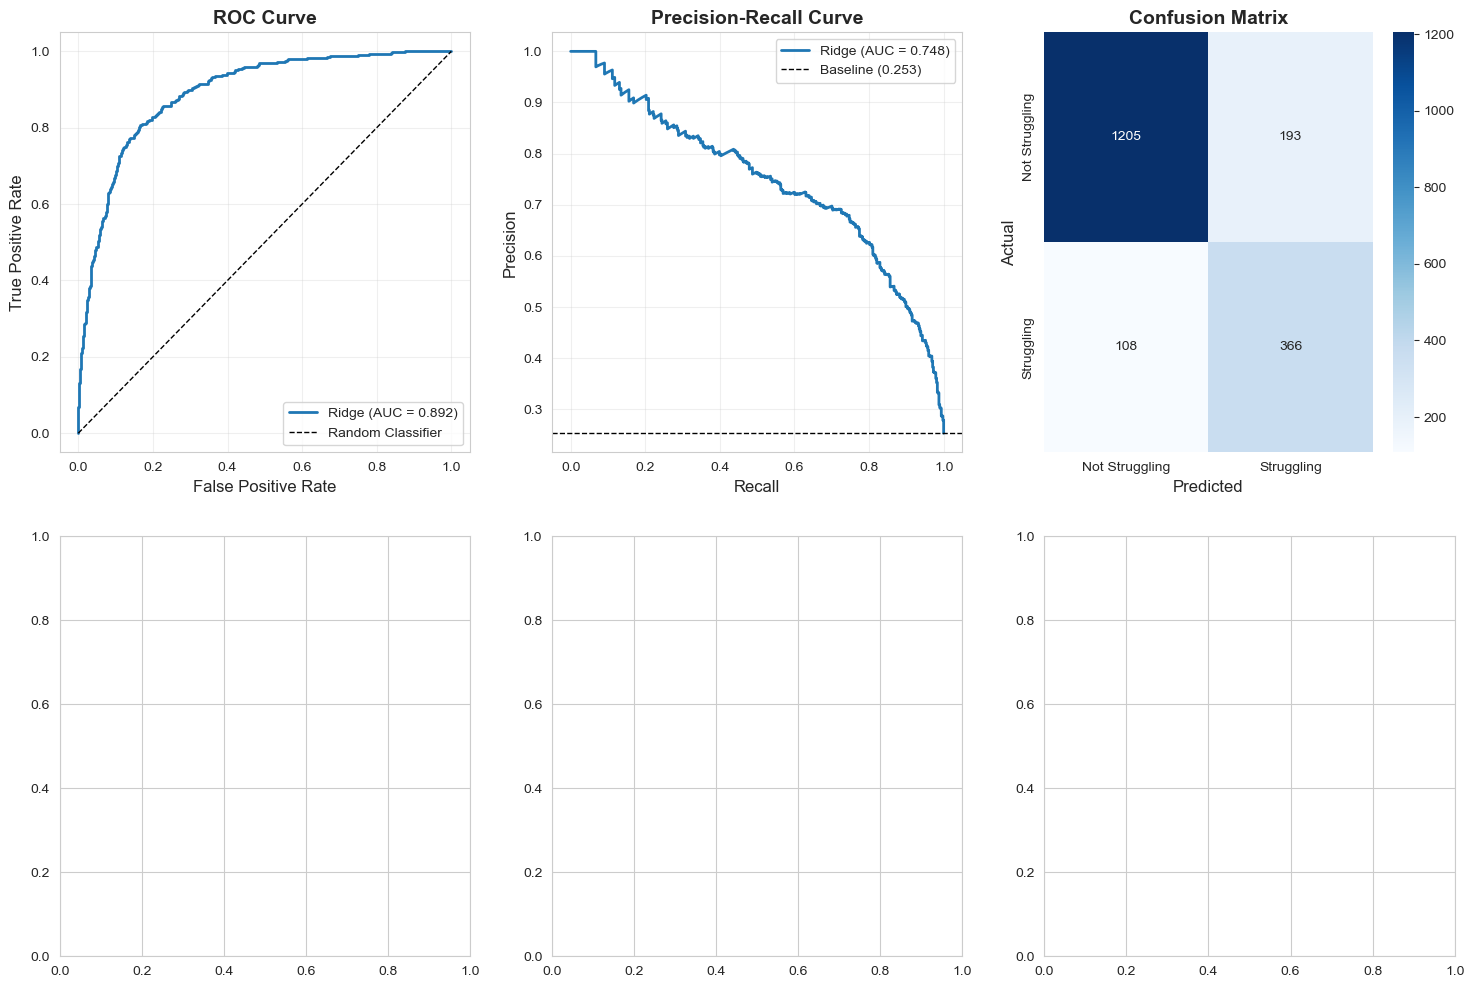

In [20]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 9.1 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob_ridge)
axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'Ridge (AUC = {roc_auc_score(y_test, y_prob_ridge):.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
axes[0, 0].set_xlabel('False Positive Rate', fontsize=12)
axes[0, 0].set_ylabel('True Positive Rate', fontsize=12)
axes[0, 0].set_title('ROC Curve', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 9.2 Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob_ridge)
pr_auc_val = auc(recall, precision)
axes[0, 1].plot(recall, precision, linewidth=2, label=f'Ridge (AUC = {pr_auc_val:.3f})')
axes[0, 1].axhline(y=y_test.mean(), color='k', linestyle='--', linewidth=1, label=f'Baseline ({y_test.mean():.3f})')
axes[0, 1].set_xlabel('Recall', fontsize=12)
axes[0, 1].set_ylabel('Precision', fontsize=12)
axes[0, 1].set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 9.3 Confusion Matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 2],
            xticklabels=['Not Struggling', 'Struggling'],
            yticklabels=['Not Struggling', 'Struggling'])
axes[0, 2].set_ylabel('Actual', fontsize=12)
axes[0, 2].set_xlabel('Predicted', fontsize=12)
axes[0, 2].set_title('Confusion Matrix', fontsize=14, fontweight='bold')

In [21]:
high_conf_fp = test_data.iloc[fp_indices[fp_probs >= 0.7]]

print("High-confidence false positives:")
print(high_conf_fp[['enrollment', 'meps_poverty_pct', 
                     'direct_certification', 'school_level_clean', 
                     'math_test_pct_prof_midpt']].describe())

# Compare to true positives
high_conf_tp = test_data.iloc[np.where((y_test == 1) & (y_pred_ridge == 1))[0]]
print("\nTrue positives for comparison:")
print(high_conf_tp[['enrollment', 'meps_poverty_pct', 
                     'direct_certification', 'school_level_clean', 
                     'math_test_pct_prof_midpt']].describe())

High-confidence false positives:
        enrollment  meps_poverty_pct  direct_certification  \
count   111.000000        111.000000            111.000000   
mean    439.648649         21.513425            269.171171   
std     233.828089          3.049829            139.119822   
min      14.000000         14.921972             11.000000   
25%     270.500000         19.319502            171.500000   
50%     399.000000         21.570396            252.000000   
75%     594.000000         23.850676            349.000000   
max    1456.000000         29.667946            716.000000   

       math_test_pct_prof_midpt  
count                 87.000000  
mean                  48.034483  
std                    9.761634  
min                   38.000000  
25%                   42.000000  
50%                   46.000000  
75%                   52.000000  
max                   82.000000  

True positives for comparison:
        enrollment  meps_poverty_pct  direct_certification  \
count   